In [1]:
ls

bert_imdb.ipynb     cnn_kd_twitter.ipynb      lstm_baseline.ipynb
bert_twitter.ipynb  cnn_twitter.ipynb         lstm_basline_Twitter.ipynb
cnn_imdb.ipynb      kd_atten_lstm_imdb.ipynb  lstm_kd_atten_twitter.ipynb
cnn_kd.ipynb        kd_lstm_imdb.ipynb        lstm_kd_twitter.ipynb


In [2]:
cd ..

/lustre03/project/6001103/dongxx


In [3]:
cd LSTMbaseline/

/lustre03/project/6001103/dongxx/LSTMbaseline


In [4]:
test = '/home/dongxx/projects/def-mercer/dongxx/IMDB_data/test.csv'
valid = '/home/dongxx/projects/def-mercer/dongxx/IMDB_data/valid.csv'
train ='/home/dongxx/projects/def-mercer/dongxx/IMDB_data/train.csv'

In [19]:
from models import CNN_Baseline,LSTMBaseline
from run_bert_ft_classifier import validate, prepare_dateset,generate_batch,epoch_time
import torch
import torch.nn as nn
import numpy as np
from models import BERTGRUSentiment
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe,Vocab,Vectors
from tqdm import tqdm
from utils import IMDB_indexing, pad_sequenc,pad_sequencing
from models import CNN_Baseline,LSTMBaseline
import torchtext.vocab
import csv
import pandas as pd
import argparse
import logging
import os
import pickle
import sys
import config
config.seed_torch()
from collections import Counter
import time
import copy

In [20]:
ls

ca.py             run_bert_ft_classifier.py
CHANGELOG.md      run_bert_training_classifier.py
cnn_kd.py         run_cnn_classifier.py
config.py         run_kd_lstm_atten_classifier.py
dataloader.py     run_kd_lstm_classifier.py
data_prepare.py   run_lstm_baseline_classifier.py
earlystopping.py  run_lstm_classifier.py
eval.py           run_lstm_kd_classifier.py
man/              testing_kd.py
model.py          test.py
models.py         train.py
__pycache__/      Untitled.ipynb
README.md         utils.py
run_atten.py


In [21]:
from transformers import BertTokenizer, BertModel

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
bert = BertModel.from_pretrained('/home/dongxx/projects/def-mercer/dongxx/bert-base-uncased')

Some weights of the model checkpoint at /home/dongxx/projects/def-mercer/dongxx/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
train_dataset, validation_dataset,test_dataset,labellist  = prepare_dateset(train, valid,test)
testing = DataLoader(test_dataset, collate_fn= generate_batch, batch_size=32, shuffle=False)

Start loading training data
Finish loading training data
Start loading validation data
Finish loading validation data
Start loading testing data
Finish loading testing data
prepare training and test sets


In [25]:
df = pd.read_csv('/home/dongxx/projects/def-mercer/dongxx/IMDB_data/test.csv')
labellist = df.Sentiment

In [27]:
BertGRU_model = BERTGRUSentiment(bert,
                                     config.HIDDEN_DIM,
                                     config.OUTPUT_DIM,
                                     config.N_LAYERS,
                                     config.BIDIRECTIONAL,
                                     config.DROPOUT)
BertGRU_model.to(device)
BertGRU_model.load_state_dict(torch.load(config.BERT_PATH))
criterion = nn.CrossEntropyLoss()
criterion.to(device)
start_time = time.time()
test_loss, test_acc,flat_list = validate(testing, BertGRU_model, criterion, device)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f' | Epoch Time: {epoch_mins}m {epoch_secs}s')





 | Epoch Time: 6m 52s


In [28]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')


Test Loss: 0.203 | Test Acc: 92.30%


In [29]:
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [31]:
import matplotlib.pyplot as plt
import itertools

In [32]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

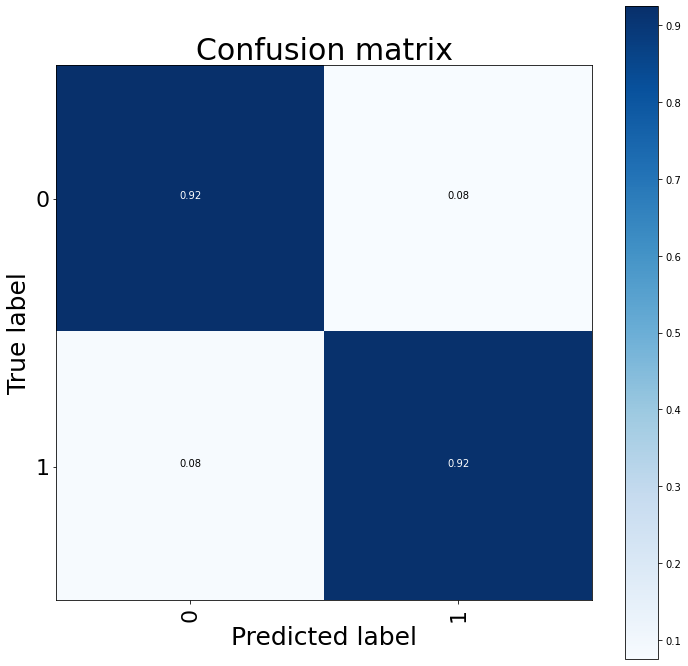

In [33]:
cnf_matrix = confusion_matrix(labellist, pred_list)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()

In [34]:
print(classification_report(labellist, pred_list))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     12500
           1       0.92      0.92      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

